In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
   

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 Images with 784 features each. 784 = 28x28 image RGB array. Each feature represents the intensity of a pixel and varies from 0 to 255.

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

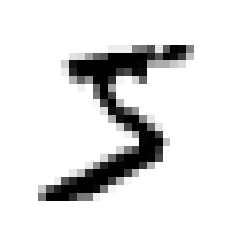

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

Before we even try to do anything, let us set aside some part of our data as test set, and not touch it until we are done training our model.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let us first start with a binary classifier. That is, classifying images into '5' or non 5 images. 

Create target vectors for this classification task as follows: 

In [ ]:
y_train_5 = (y_train == 5)    #True for all 5, False for other digits.
y_test_5 = (y_test == 5)


Stochastic
Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This clas‐
sifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s create
an SGDClassifier and train it on the whole training set:

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

In [ ]:
sgd_clf.predict([some_digit])

## Performance Measures

#### Evaluating a Classifier is more complex than a Regressor. 
Now we will measure accuracy using Cross Validation. 

In [ ]:
#Like earlier, let us use Scikit-Learn's cross_val_score() function.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [ ]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

In [ ]:
#Woah the accuracy is way too high.
#Let us see what happens if we classify all images as non-5. 

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

###### Note:-
Even when we classified all images as non 5, we got 90% accuracy. This means that more than 90% of numbers in the MNIST dataset are non-5. Hence the data is highly skewed in this case. 
Hence accuracy is not the preferred performance measure for Classifiers, especially those with skewed datasets like this one. 

### Confusion Matrix

To check the performance of a Classifier, a better way would be to look at the number of errors, or the number of times the classifier classified an image incorrectly. hence we construct a confusion matrix. 
# 

For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5 th row and 3 rd column of the confusion
matrix.

# 

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets. Let us use cross_val_predict() function for that.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)


Just like cross_val_score() performs K-fold cross validation and returns evaluation scores, cross_val predict() does the same, but returns predictions made on each test fold. Also, the prediction in this case is clean as the model does not see the data during training in this case. 

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives).